# `DEPRESJON` - Exploring Gender Specific Machine Learning Models
## Model 1: Row (Person Days) prediction

>Garcia-Ceja, E., Riegler, M., Jakobsen, P., Tørresen, J., Nordgreen, T., Oedegaard, K.J. and Fasmer, O.B. (2018) Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In: Proceedings of the 9th ACM Multimedia Systems Conference [online]MMSys ’18: 9th ACM Multimedia Systems Conference. Amsterdam Netherlands: ACM, pp. 472–477. Available from: https://dl.acm.org/doi/10.1145/3204949.3208125 [Accessed 2 December 2023].

**Objectives**

* Recreate baseline models for Female/Male/All observations as done by (Garcia-Ceja et al., 2018)

**Files in Series**

* [wiki-08-base-1-eda](.\wiki-08-base-1-eda.ipynb)
* [wiki-08-base-2-person-days-rows](.\wiki-08-base-2-person-days-rows.ipynb)
* [wiki-08-base-3-person-prediction](.\wiki-08-base-3-person-prediction.ipynb)
* [wiki-08-base-4-person-hours.ipynb](.\wiki-08-base-4-person-hours.ipynb)


## Features

>"Each day was characterized by a feature vector which was computed by extracting a set of features **on a per day basis from the activity level**. The extracted features were the **mean activity level**, the corresponding **standard deviation** and the **percentage of events with no activity i.e, activity level = 0**. The features were **normalized between 0 and 1** before the classification." (Garcia-Ceja et al., 2018)

1. Create baseline features on "per day basis":

* `mean activity level`
* `standard deviation`
* `percentage of events with no activity`

2. Normalise features between 0 and 1



In [1]:
# import from csv
import pandas as pd
input_csv_path = '../data/petter/wiki-08-garcia.csv'
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

In [2]:
# load functions in python file with magic command
%run ../code/wiki-08-base-functions.py

In [3]:
import pandas as pd

# group data by date and id (person and days)
grouped = df.groupby(['date', 'id'])


# features for each date-id combination - mean, std, and percentage of zeros
features = grouped['activity'].agg(['mean', 'std', lambda x: (x == 0).mean()])
features.columns = ['mean_activity', 'std_activity', 'pct_no_activity']

# reset index to make it a regular dataframe
features = features.reset_index()

# join with the original dataframe to get the labels
df_with_features = df.merge(features, on=['id','date'], how='left')

# normalise the features between 0 and 1
df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] = (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']] - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min()) / (
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].max() - 
    df_with_features[['mean_activity', 'std_activity', 'pct_no_activity']].min())

# drop unnecessary columns
#df_processed = df_with_features.drop(['timestamp', 'activity'], axis=1)
df_processed = df_with_features.drop(['timestamp', 'activity', 'age', 'activity_norm', 'day_of_week', 'hour_of_day'], axis=1)

# remove duplicate rows
df_processed = df_processed.drop_duplicates()

In [4]:
print(features.head())

        date            id  mean_activity  std_activity  pct_no_activity
0 2002-05-25  condition_20      72.238194    149.511740         0.568750
1 2002-05-26  condition_20      61.306250    154.005830         0.625000
2 2002-05-27  condition_20      72.115278    152.556990         0.543056
3 2002-05-28  condition_20      91.186111    180.270903         0.535417
4 2002-05-29  condition_20      32.315972    107.570967         0.775000


## Split datasets

1. Split by female/male/all
2. Split each into train/test

In [5]:
# create all, male, female dfs
both = df_processed.copy()
male = df_processed[df_processed['gender'] == 2]
female = df_processed[df_processed['gender'] == 1]


In [6]:
# list of variable names to delete
var_list = ['grouped', 'features', 'df_with_features', 'df', 'df_processed']
# delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]

Splitting into Train/Test with `split data` does not guarantee that a person's rows are not split between the two datasets.

In [10]:
# split each dataset into train and test sets
X_train_both, y_train_both, X_test_both, y_test_both = split_data(both, random_state=5, deleteXy=True)
X_train_male, y_train_male, X_test_male, y_test_male = split_data(male, random_state=5, deleteXy=True)
X_train_female, y_train_female, X_test_female, y_test_female = split_data(female, random_state=5, deleteXy=True)

In [12]:
# print info
print("Both dataset:")
print(f"Train set: {X_train_both.shape[0]} samples")
print(f"Test set: {X_test_both.shape[0]} samples")
print("\nMale dataset:")
print(f"Train set: {X_train_male.shape[0]} samples")
print(f"Test set: {X_test_male.shape[0]} samples")
print("\nFemale dataset:")
print(f"Train set: {X_train_female.shape[0]} samples")
print(f"Test set: {X_test_female.shape[0]} samples")

Both dataset:
Train set: 554 samples
Test set: 139 samples

Male dataset:
Train set: 248 samples
Test set: 62 samples

Female dataset:
Train set: 306 samples
Test set: 77 samples


## Model

* Single run of several models for each `both`, `female` and `male` datasets
* No model tuning
* Basic comparison

**Observation** is that when splitting into `train` and `test` sets, there is no guarantee that a person's rows (in this case, date+person) are not split between the two sets.  That is, people are not maintained across the datasets. 

**Predicting depression state of a person's day (row level) does not make sense, in my view.  We are interested in predicting a person's depression state - not whether a person's day is depresseed.** 


In [13]:
# list of models
# zeroR is loaded from functions file
# libraries loaded from function file
models = [
    ('ZeroR', ZeroRClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC(dual=False, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(max_iter=1000)),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier(verbose=-1)),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME')),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
    ('SVM rbf', SVC(kernel='rbf')),
    ('SVM linear', SVC(kernel='linear')),
    ('Gaussian Process', GaussianProcessClassifier())
]

In [14]:
# empty dictionary to store results
all_results = {}

# single_run for each dataset
for dataset_name in ['both', 'male', 'female']:
    X_train = locals()[f"X_train_{dataset_name}"]
    X_test = locals()[f"X_test_{dataset_name}"]
    y_train = locals()[f"y_train_{dataset_name}"]
    y_test = locals()[f"y_test_{dataset_name}"]

    # single_run 
    results = single_run(X_train, X_test, y_train, y_test, models)

    # store the results in the all_results dictionary
    all_results[dataset_name] = results


c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

In [16]:
# print metrics (dataset, model, metric - can use 'all' for everything) - needs 'all_results' dictionary
print_model_metric(all_results, dataset = 'both', model = 'SVM rbf')
print("\n")
print_model_metric(all_results, dataset = 'male', model = 'SVM rbf', metric='all')
print("\n")
print_model_metric(all_results, dataset = 'female', model = 'SVM rbf')

both dataset elapsed_time for SVM rbf: 0.005937814712524414
both dataset accuracy for SVM rbf: 0.7266187050359713
both dataset precision for SVM rbf: 0.6444444444444445
both dataset recall for SVM rbf: 0.5686274509803921
both dataset f1 for SVM rbf: 0.6041666666666666
both dataset specificity for SVM rbf: 0.8181818181818182
both dataset mcc for SVM rbf: 0.3984309922914437
both dataset roc_auc for SVM rbf: 0.693404634581105


male dataset elapsed_time for SVM rbf: 0.0009989738464355469
male dataset accuracy for SVM rbf: 0.7741935483870968
male dataset precision for SVM rbf: 0.84375
male dataset recall for SVM rbf: 0.75
male dataset f1 for SVM rbf: 0.7941176470588235
male dataset specificity for SVM rbf: 0.8076923076923077
male dataset mcc for SVM rbf: 0.5506770308517437
male dataset roc_auc for SVM rbf: 0.7788461538461539


female dataset elapsed_time for SVM rbf: 0.0009987354278564453
female dataset accuracy for SVM rbf: 0.7922077922077922
female dataset precision for SVM rbf: 1.0
fema

In [17]:
# print best results for each dataset
for dataset_name, dataset_results in all_results.items():
    for metric in ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'mcc']:
        print_top_models(dataset_name, dataset_results, metric)
    print_second_fastest_model(dataset_name, dataset_results)
    print("\n")


Top 3 models for both dataset based on accuracy:
1. Naive Bayes: 0.7266187050359713
2. Neural Network: 0.7266187050359713
3. SVM rbf: 0.7266187050359713

Top 3 models for both dataset based on precision:
1. Neural Network: 0.6511627906976745
2. SVM rbf: 0.6444444444444445
3. Gaussian Process: 0.6428571428571429

Top 3 models for both dataset based on recall:
1. QDA: 0.7058823529411765
2. Gradient Boosting: 0.6274509803921569
3. Naive Bayes: 0.6078431372549019

Top 3 models for both dataset based on specificity:
1. ZeroR: 1.0
2. Neural Network: 0.8295454545454546
3. SVM linear: 0.8295454545454546

Top 3 models for both dataset based on f1:
1. QDA: 0.6486486486486487
2. Naive Bayes: 0.62
3. SVM rbf: 0.6041666666666666

Top 3 models for both dataset based on mcc:
1. QDA: 0.4214835852612645
2. Naive Bayes: 0.4068486282170665
3. SVM rbf: 0.3984309922914437

Fastest model (elapsed time) for both dataset:
Naive Bayes: 0.0



Top 3 models for male dataset based on accuracy:
1. QDA: 0.77419354

### Interpretation of Single Run

* The models perform well 'out-of-the-box' and results are quite similar between models and between datasets. 
* Results can vary significantly with different seeds, indicating that there is not much between the models.  
* The results above are from a `single run` with a fixed seed - changing seeds and performing another `single run` will result in different outcomes.


1. **Performance** overall

* Top performing models vary across the three datasets, suggesting the *potential* influence of gender-specific charactersitics on the model performance
* `Naive Bayes`, `Neural Network`, and `SVM rbf` perform well in terms of accuracy across all datasets.
* `Neural Network` consistently ranks high in precision across all datasets, indicating its ability to minimise false positives.


* This could mean that it is worthwhile pursuing separate models by gender and including additional gender-specific features.
  

1. **Trade-offs**
* There are trade-offs between metrics - this shows the importance of considering multiple metrics and prioritising them against specific requirements and use-cases, especially taking into account the consequences of false positives and false negatives when applying the model - e.g. in a clinical setting. 
* **Precision v Recall**
   * Precision measurees the proportion of true positive instances among all postive predictions; recall measures proportion of actual positive instances which were correctly identified.  
   * Classification models can prioritise precision or recall.
   * **High precision - Low Recall**: when decision threshold for positive classification is very high - that is, conservative at predicting positive instances.
     * For example, high precision is when most predicted depression is true depression, but low recall is when many true depressions are missed.
   * **Low precision - High Recall**: when decision threshold for positive classification is liberal. 
     * Many cases are predicted to be 'depressed' (false positives) when they are not.
   * **F1** - harmonic mean to balance this situation.
   * `male` dataset has high precision with AdaBoost (0.92) but lower recall (0.63)
   * `female` dataset best model has a lower F1 (0.6) than `male` (0.80) or `both` (0.64).  This could be due to potential bias or because of underlying differences in the data patterns or distributions.
 * **Accuracy v MCC**
   * Matthews Correlation Coefficient is a powerful metric useed to evaluate binary classification models - especially useful for imbalanced datasets or where false postive / false negative costs are different.  It takes into account all four confusion matrix elements - TP, TN, FP, FN.
   * The MCC is a balanced measure, robust to class imbalance, easy to interpret (-1 to 1) and allows for fair comparison between model performance.
   * For each dataset, the MCC (~0.4-0.5) score is a lot lower than the accuracy (~0.7-0.8).  This could be due to class imbalance or misclassification patterns (bearing in mind very basic features).
   * But `both` has an MCC of 0.42 compared to 0.56 for `female` and `male` which suggests that the gender-specific models may be performing better - or is there a need for more data (or a different dataset)?

  Of particular note are the many `1.0` results with the `female` dataset - see `precision` and `specificity`.
  * Precision is the proportion of true positive predictions among all positive predictions, so all instances predicted to be positive were true positives - that is, no false positive predictions were made. 
  * Specificity is the proportion of true negative instances that were correctly identified out of all negative instances, so all actual negative (not depressed) instances were correctly identified.  Essentially, the omdel did not misclassify any negative instances as positive in its predictions.
  * This could be due to **overfitting** or other **anomalies** or **evaluation** issues.  Needs to be evaluated robustly for reliability and generalisability.  Recall this is a single run on a small dataset.

### Statistical test for signficance

Performing `Wilcoxon rank-sum` (aka Mann-Witney U) to see if there is a statistically significant difference between datast metrics.
* Wilcoxon rank sum is non-parametric (does not assume normal distribution)
* There is no significant difference.
* This could be:
  * Small sample size - one value for each metric of each dataset
  * Magnitude of difference is not large enough
  * Outliers, distributional differences not accounted for (recall, minimal data processing)
  * Significance does not mean that gender-specific models should be abandoned 

In [18]:
import scipy.stats as stats

metrics = ['f1', 'accuracy', 'precision', 'recall', 'specificity', 'mcc']
significant_results_found = False

for model_name, model_results in all_results['both'].items():
    for metric in metrics:
        male_result = all_results['male'][model_name][metric]
        female_result = all_results['female'][model_name][metric]
        all_result = model_results[metric]

        # Wilcoxon rank-sum test
        _, p_val_male = stats.ranksums(male_result, all_result)
        _, p_val_female = stats.ranksums(female_result, all_result)

        if p_val_male < 0.05 or p_val_female < 0.05:
            print(f"Model: {model_name}")
            print(f"Metric: {metric}")
            if p_val_male < 0.05:
                print("The performance on the 'male' dataset is significantly different from the 'all' dataset.")
                print(f"p-value for 'male' vs. 'all': {p_val_male}")
            if p_val_female < 0.05:
                print("The performance on the 'female' dataset is significantly different from the 'all' dataset.")
                print(f"p-value for 'female' vs. 'all': {p_val_female}")
            print("\n")
            significant_results_found = True

if not significant_results_found:
    print("No statistically significant differences were found.")

No statistically significant differences were found.


Re-running with `cross-validation` using the entire dataset.

In [19]:
# prepare all, male, female into dictionary of X and y
datasets = {

    'male': {
        'X': both[both['gender'] == 2][['mean_activity', 'std_activity', 'pct_no_activity']].values,
        'y': both[both['gender'] == 2]['label'].values
    },
    'female': {
        'X': both[both['gender'] == 1][['mean_activity', 'std_activity', 'pct_no_activity']].values,
        'y': both[both['gender'] == 1]['label'].values
    }
}

# update models to dictionary
models = {
    'ZeroR': ZeroRClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Linear SVC': LinearSVC(dual=False, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(force_col_wise=True, verbose=-1),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Gradient Boosting': GradientBoostingClassifier(), 
    'SVM rbf': SVC(kernel='rbf'),
    'SVM linear': SVC(kernel='linear'),
    'Gaussian Process': GaussianProcessClassifier()
}

In [20]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold

metrics = ['f1', 'accuracy', 'precision', 'recall', 'specificity', 'mcc']
num_folds = 5  #  cross-validation folds

for model_name, model in models.items():
    for dataset_name, dataset in datasets.items():
        X, y = dataset['X'], dataset['y']
        cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
        metric_values = []
        significant_difference_found = False  #  flag initialisation

        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # metric values for current fold
            metric_values.append({
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'specificity': recall_score(y_test, y_pred, pos_label=1),
                'mcc': matthews_corrcoef(y_test, y_pred)
            })

        # compare metric distributions between datasets
        for metric in metrics:
            dataset_metric_values = [fold_metrics[metric] for fold_metrics in metric_values]
            all_metric_values = all_results['both'][model_name][metric]

            _, p_val = stats.ranksums(dataset_metric_values, all_metric_values)
            if p_val < 0.05:
                print(f"Model: {model_name}")
                print(f"Metric: {metric}")
                print(f"Dataset: {dataset_name}")
                print(f"p-value for comparing with 'all' dataset: {p_val}")
                print("The performance is significantly different from the 'all' dataset.")
                print("\n")
                significant_difference_found = True  # set flag

        if not significant_difference_found:
            print(f"No statistically significant differences were found for model {model_name} on dataset {dataset_name}.")


No statistically significant differences were found for model ZeroR on dataset male.
No statistically significant differences were found for model ZeroR on dataset female.


c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zoona\Anacond

No statistically significant differences were found for model Random Forest on dataset male.
No statistically significant differences were found for model Random Forest on dataset female.
No statistically significant differences were found for model Linear SVC on dataset male.
No statistically significant differences were found for model Linear SVC on dataset female.
No statistically significant differences were found for model Decision Tree on dataset male.
No statistically significant differences were found for model Decision Tree on dataset female.
No statistically significant differences were found for model Logistic Regression on dataset male.
No statistically significant differences were found for model Logistic Regression on dataset female.
No statistically significant differences were found for model KNN on dataset male.
No statistically significant differences were found for model KNN on dataset female.
No statistically significant differences were found for model Naive Bayes 

No statistically significant differences with cross-validated (n=5) approach.

### Visualising metrics

In [21]:
import pandas as pd

# empty list 
data = []

# iterate over datasets
for dataset_name, dataset_results in all_results.items():
    # iterate over models
    for model_name, model_results in dataset_results.items():
        # iterate over metrics
        for metric_name, metric_value in model_results.items():
            data.append({
                'model': model_name,
                'metric_name': metric_name,
                'metric_value': metric_value,
                'dataset': dataset_name
            })

# df
singles = pd.DataFrame(data)

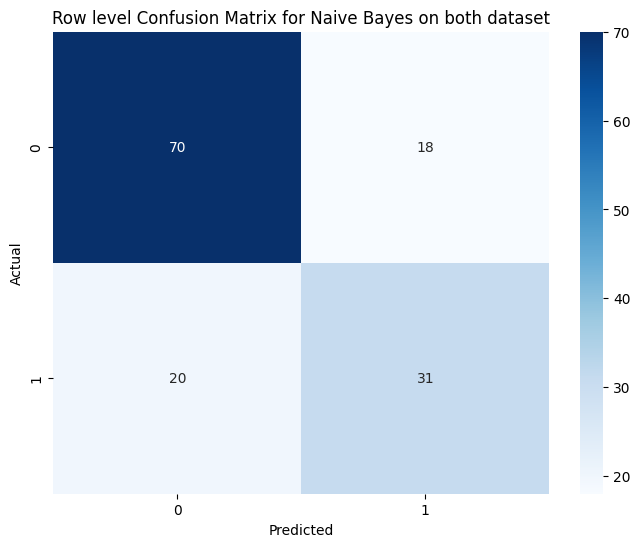

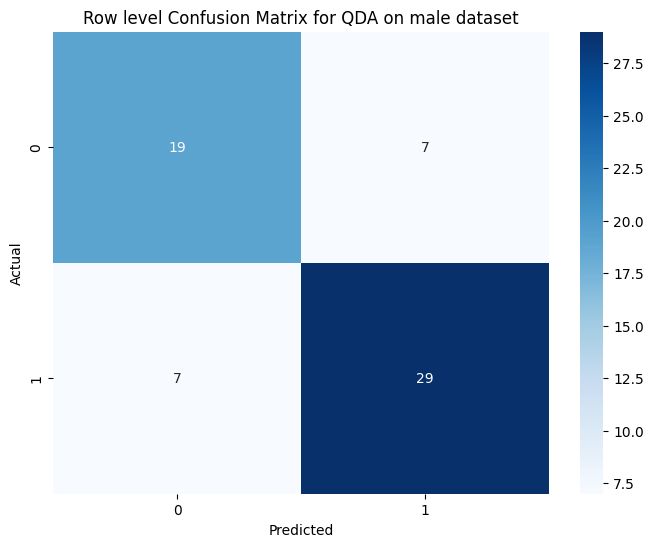

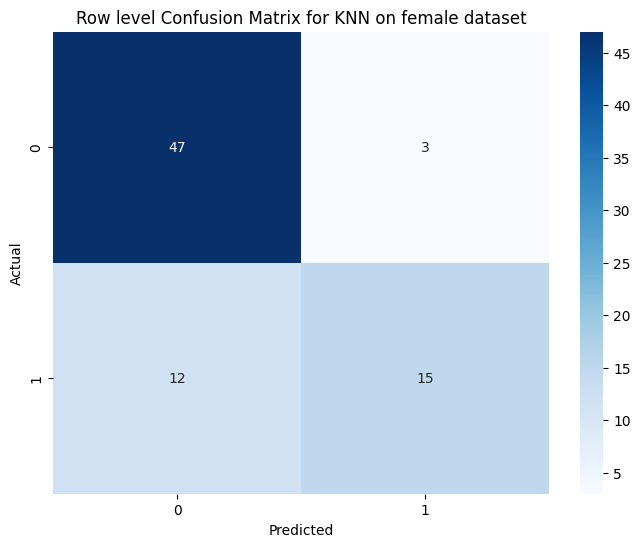

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

for dataset_name, dataset_results in all_results.items():
    # sort the models based on accuracy
    accuracy_sorted = sorted(dataset_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    # best performing model
    best_model_name, best_model_results = accuracy_sorted[0]
    
    # confusion matrix
    cm = best_model_results['cm']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f"Row level Confusion Matrix for {best_model_name} on {dataset_name} dataset")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()